In [3]:
#General imports

In [4]:
import os
import joblib

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
#Machine Learning imports

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [10]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, StackingRegressor

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Import & Aggregation

In [12]:
DATA_PATH = 'C:\\My Work\\Projects\\Machine Learning\\Walmart Sales Forecasting\\datasets\\'#local folder

In [13]:
print('Loading data...')
print(os.listdir(DATA_PATH))

Loading data...
['features.csv', 'stores.csv', 'test.csv', 'train.csv']


In [14]:
FEATURE_PATH = DATA_PATH + 'features.csv'
STORES_PATH = DATA_PATH + 'stores.csv'
TRAIN_PATH = DATA_PATH + 'train.csv'
TEST_PATH = DATA_PATH + 'test.csv'

In [15]:
#Created variables for each dataset path is to make this portion less dependent.
#Even if I need to change or move the data to somewhere else, the effort will be minimal
#A better option would have been to create a config file for the same.

In [16]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
features = pd.read_csv(FEATURE_PATH)
stores = pd.read_csv(STORES_PATH)

In [17]:
train.head(20)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [18]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [19]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [20]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [21]:
#merging the data

class DataMerger(BaseEstimator, TransformerMixin):
    def __init__(self,fpath = FEATURE_PATH, spath = STORES_PATH):
        self.fpath = fpath
        self.spath = spath
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        feature = pd.read_csv(self.fpath)
        store = pd.read_csv(self.spath)
        df = X.merge(feature, how = 'inner', on =['Store', 'Date', 'IsHoliday'])
        df = df.merge(store, how = 'inner', on =['Store'])
        return df

In [22]:
dm = DataMerger(FEATURE_PATH, STORES_PATH)
trainSales = dm.transform(train)
trainSales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


# 2. Data Analysis

In [23]:
trainSales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [24]:
#trainSales['IsHoliday'].value_counts()

In [25]:
# trainSales['HolidayFlag'] = trainSales['IsHoliday'].apply(lambda x : 0 if x == False else 1)
# holidaySales = trainSales.drop(columns = ['IsHoliday'], axis=1)
# holidaySales.head()

***Check Date***

In [26]:
#Due to some reason it is being observed that sales information taken only on Friday 
#and not on other days regardless of the year

#If that is true then maybe we need to revisit our strategy on the date columns 

#We do not need any validation for weekend 'coz no date ins a weekend.

In [28]:
#Lets have seperate columns for month, year and week_of_month

trainSales['Year'] = trainSales['Date'].astype('datetime64').dt.year
trainSales['Month'] = trainSales['Date'].astype('datetime64').dt.month
trainSales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2


In [29]:
def week_of_month(df):
    dff = df.copy()
    dff['date_week'] = dff['Date'].astype('datetime64').dt.isocalendar().week
    dff['date_month'] = dff['Date'].astype('datetime64').dt.month
    dff['date_year'] = dff['Date'].astype('datetime64').dt.year
    
    dff[['date_start']] = '01'
    
    dff['ref_date'] = dff['date_year'].astype('str') + '-' + dff['date_month'].astype('str') + '-' + dff['date_start'].astype('str')
    dff['ref_week'] = dff['ref_date'].astype('datetime64').dt.isocalendar().week
    dff.loc[dff['ref_week'] == 52, 'ref_week'] = 0
    
    dff['WOM'] = (dff['date_week'] - dff['ref_week']) + 1
    
    return dff['WOM']

In [30]:
trainSales['Week_of_Month'] = week_of_month(trainSales[['Date']])

trainSales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Year,Month,Week_of_Month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,1
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,1
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,1
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,1
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2010,2,1


In [36]:
sales['Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [37]:
sales['Month'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1], dtype=int64)

In [38]:
sales['Week_of_Month'].unique()

<IntegerArray>
[1, 2, 3, 4, 5]
Length: 5, dtype: UInt32

In [32]:
#More than half of the rows are null for the Markdown columns
#Since I do not have much information available about these columns, removing these.
#Date column can be removed now.

sales = trainSales.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown4', 'MarkDown5', 'Date'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Store          421570 non-null  int64  
 1   Dept           421570 non-null  int64  
 2   Weekly_Sales   421570 non-null  float64
 3   IsHoliday      421570 non-null  bool   
 4   Temperature    421570 non-null  float64
 5   Fuel_Price     421570 non-null  float64
 6   CPI            421570 non-null  float64
 7   Unemployment   421570 non-null  float64
 8   Type           421570 non-null  object 
 9   Size           421570 non-null  int64  
 10  Year           421570 non-null  int64  
 11  Month          421570 non-null  int64  
 12  Week_of_Month  421570 non-null  UInt32 
dtypes: UInt32(1), bool(1), float64(5), int64(5), object(1)
memory usage: 41.0+ MB


In [33]:
sales.isnull().sum()

Store            0
Dept             0
Weekly_Sales     0
IsHoliday        0
Temperature      0
Fuel_Price       0
CPI              0
Unemployment     0
Type             0
Size             0
Year             0
Month            0
Week_of_Month    0
dtype: int64

In [34]:
sales.sample(10)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,Month,Week_of_Month
394281,42,38,32634.70,False,78.62,3.933,129.062355,8.494,C,39690,2011,5,5
110787,12,58,2556.00,True,47.66,3.162,126.669267,14.313,B,112238,2010,11,4
255105,26,9,18434.73,False,52.55,3.899,138.106581,7.489,A,152513,2012,5,3
35927,4,29,10222.96,False,64.79,3.361,129.782161,5.143,A,205863,2011,10,4
230683,24,40,45544.35,True,26.51,3.416,133.260871,8.252,A,203819,2011,2,2
339996,35,58,1150.00,False,64.92,3.997,142.765750,8.839,B,103681,2012,9,5
164647,17,41,-36.00,False,26.26,3.077,130.349677,6.403,B,93188,2012,2,1
274710,28,21,5960.31,False,54.54,4.250,130.741379,12.187,A,206302,2012,3,2
372130,40,83,4202.71,False,67.88,2.906,132.293936,5.435,A,155083,2010,5,5
318283,33,97,4055.83,True,62.35,3.760,129.836400,8.010,A,39690,2011,11,4


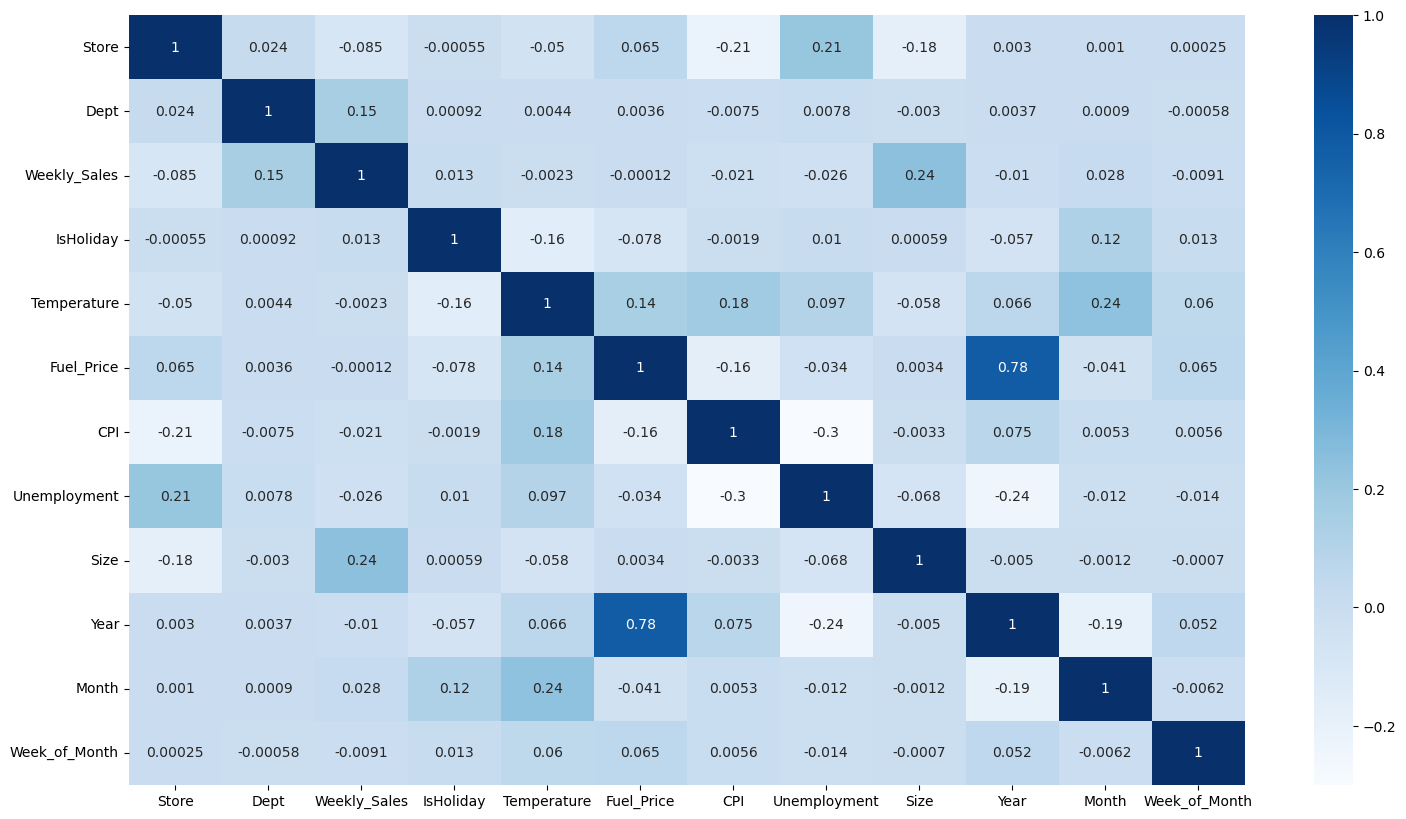

In [59]:
#Lets try to see the inter-dependency among the columns

plt.figure(figsize=(18, 10))

sales_cr = sales.corr()
sns.heatmap(sales_cr, annot=True, cmap='Blues')
plt.show()

In [42]:
sales.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
CPI,421570.0,171.201947,39.159276,126.064,132.022667,182.31878,212.416993,227.232807
Unemployment,421570.0,7.960289,1.863296,3.879,6.891000,7.86600,8.572000,14.313000
Size,421570.0,136727.915739,60980.583328,34875.000,93638.000000,140167.00000,202505.000000,219622.000000
Year,421570.0,2010.968591,0.796876,2010.000,2010.000000,2011.00000,2012.000000,2012.000000
Month,421570.0,6.449510,3.243217,1.000,4.000000,6.00000,9.000000,12.000000


In [56]:
numeric_columns = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
category_columns = ['Store', 'Dept', 'IsHoliday', 'Year', 'Month', 'Week_of_Month', 'Type']

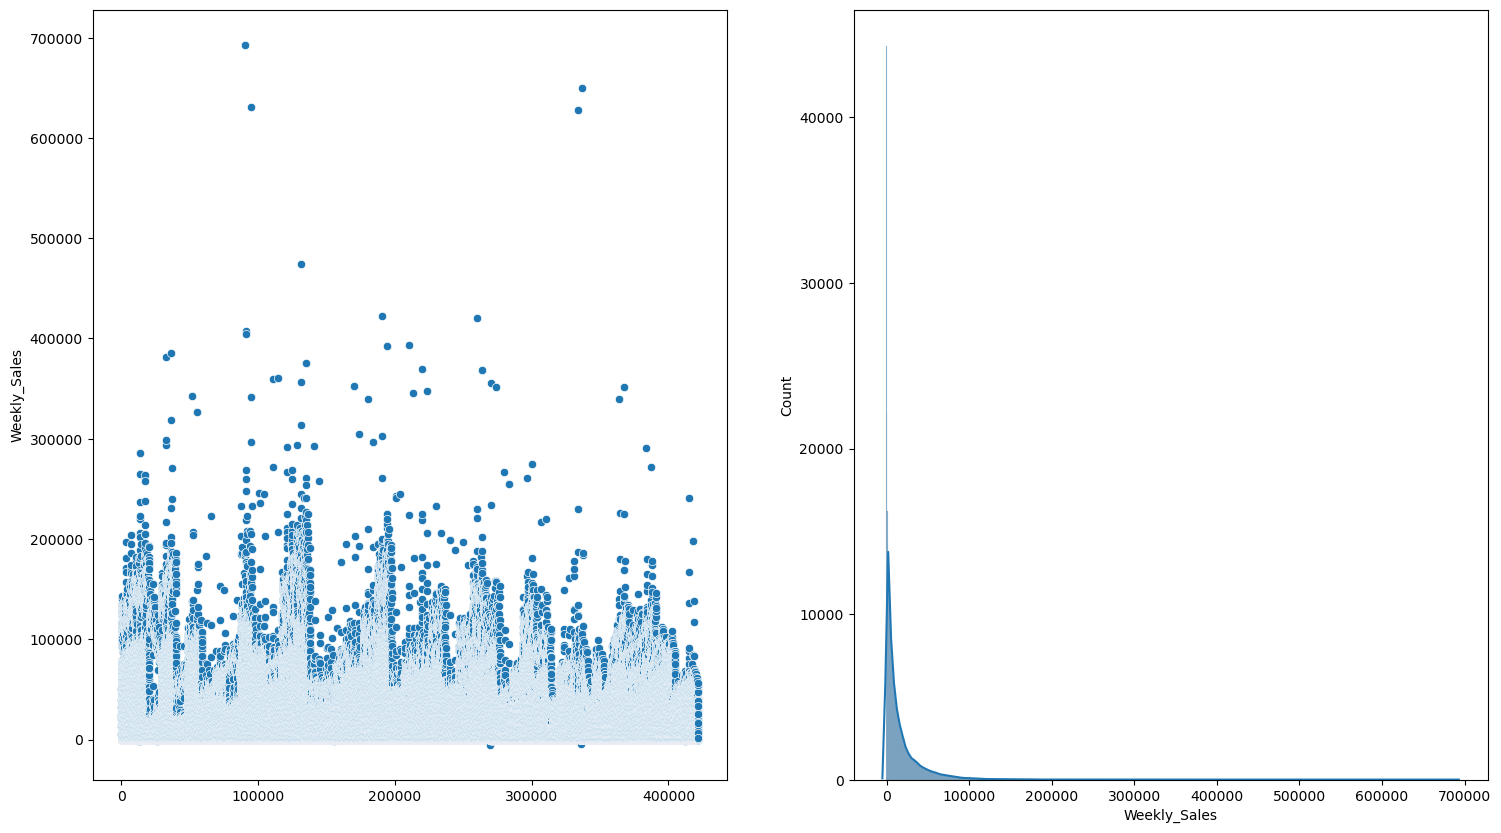

In [40]:
#Plotting the target

fig, ax = plt.subplots(1, 2, figsize=(18, 10))

sns.scatterplot(y='Weekly_Sales', x = sales.index, data=sales, ax = ax[0])
sns.histplot(x = 'Weekly_Sales', data=sales, kde=True, ax = ax[1])
fig.show()

In [48]:
def dist_plot(df, columns, kind='scatter', label = 'Weekly_Sales', basis = None):
    plt.figure(figsize=(18, 10))
    
    for idx, column in enumerate(columns):
        f = plt.subplot(3, 3, idx + 1)
        
        if kind == 'scatter':
            g = sns.scatterplot(x =  column, y = label, data = df, hue = basis)
        elif (kind == 'histplot'):
            g = sns.histplot(x = column, data = df, kde = True, hue = basis)
        elif (kind == 'boxplot'):
            g = sns.boxplot(x = column, data = df, hue = basis)
            
    plt.tight_layout()
    
    
def cat_plot(df, columns, kind='countplot', label='Weekly_Sales', basis = None):
    plt.figure(figsize=(18, 10))
    
    for idx, column in enumerate(columns):
        f = plt.subplot(3, 3, idx + 1)
        
        if kind == 'countplot':
            g = sns.countplot(x = column, data=df, hue=basis)
            
        if kind == 'barplot':
            g = sns.barplot(x = column, y = label, data=df, hue=basis)
            
    plt.tight_layout()

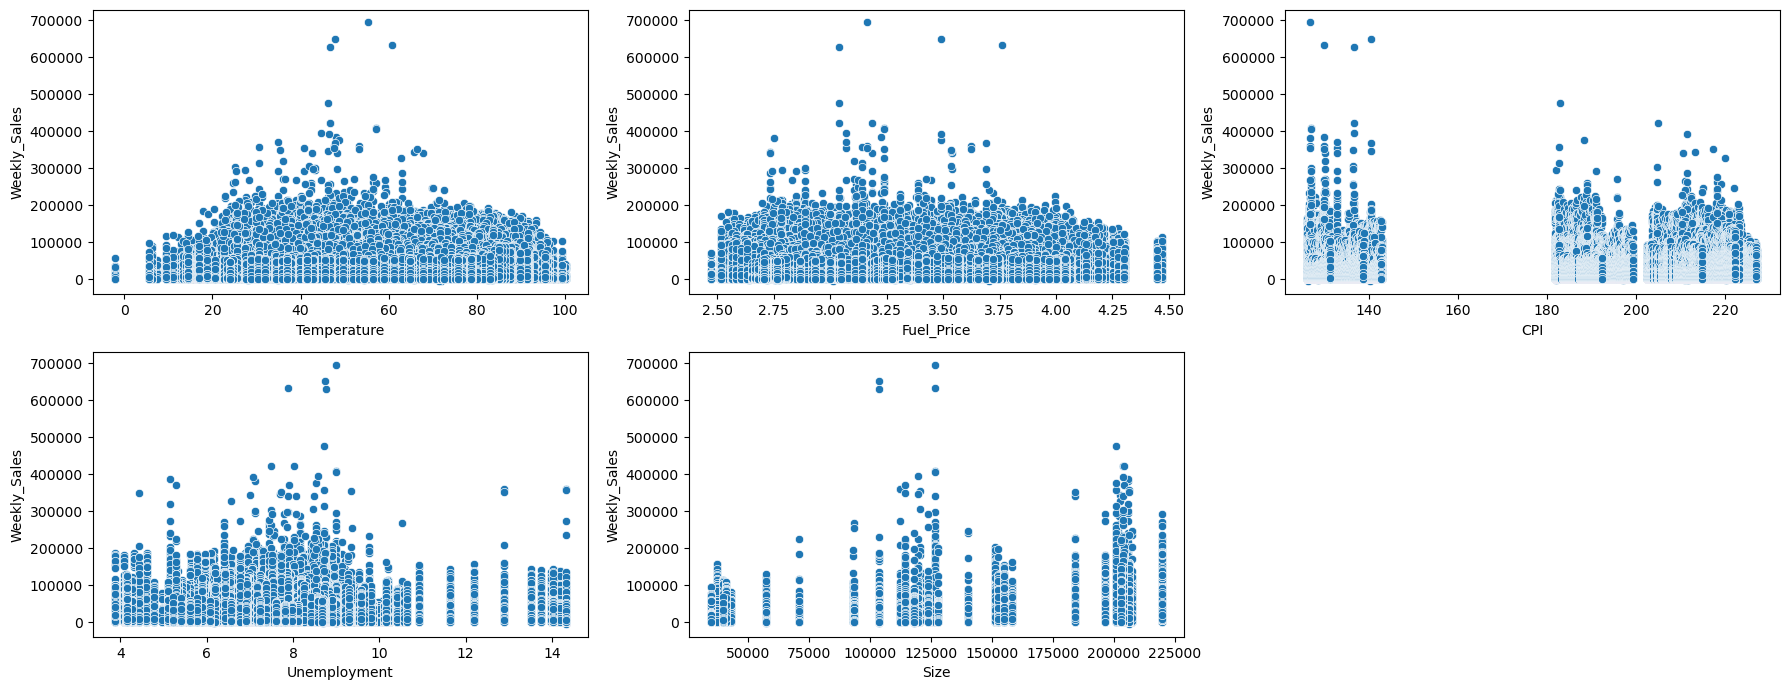

In [49]:
dist_plot(sales, numeric_columns)

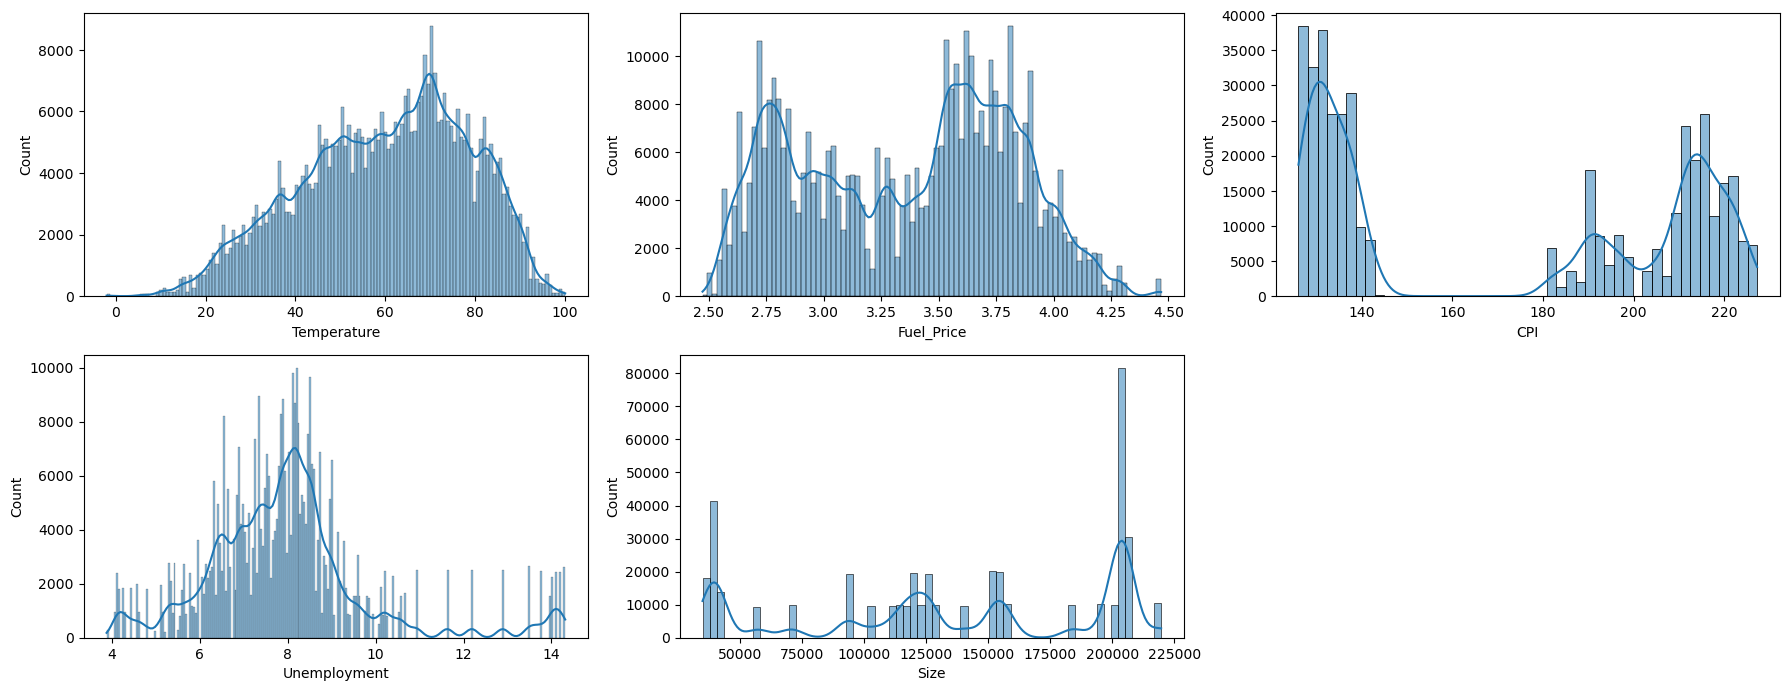

In [52]:
dist_plot(sales, numeric_columns, kind='histplot')

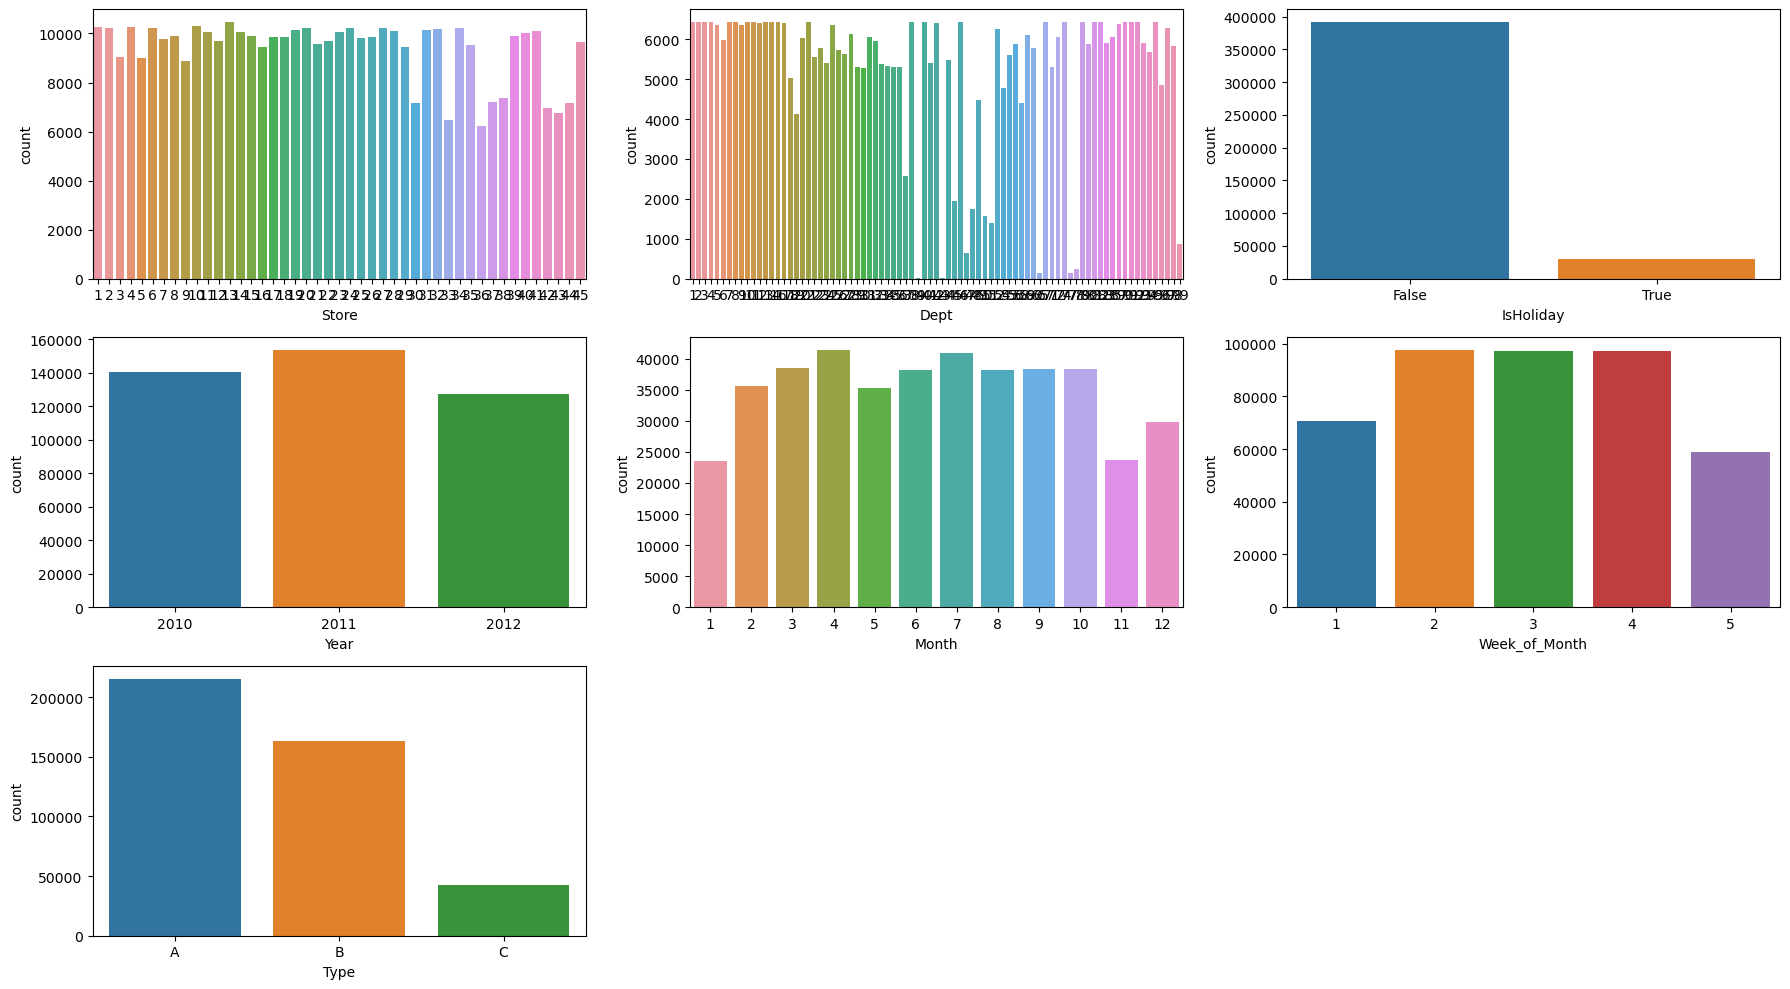

In [60]:
cat_plot(sales, category_columns)

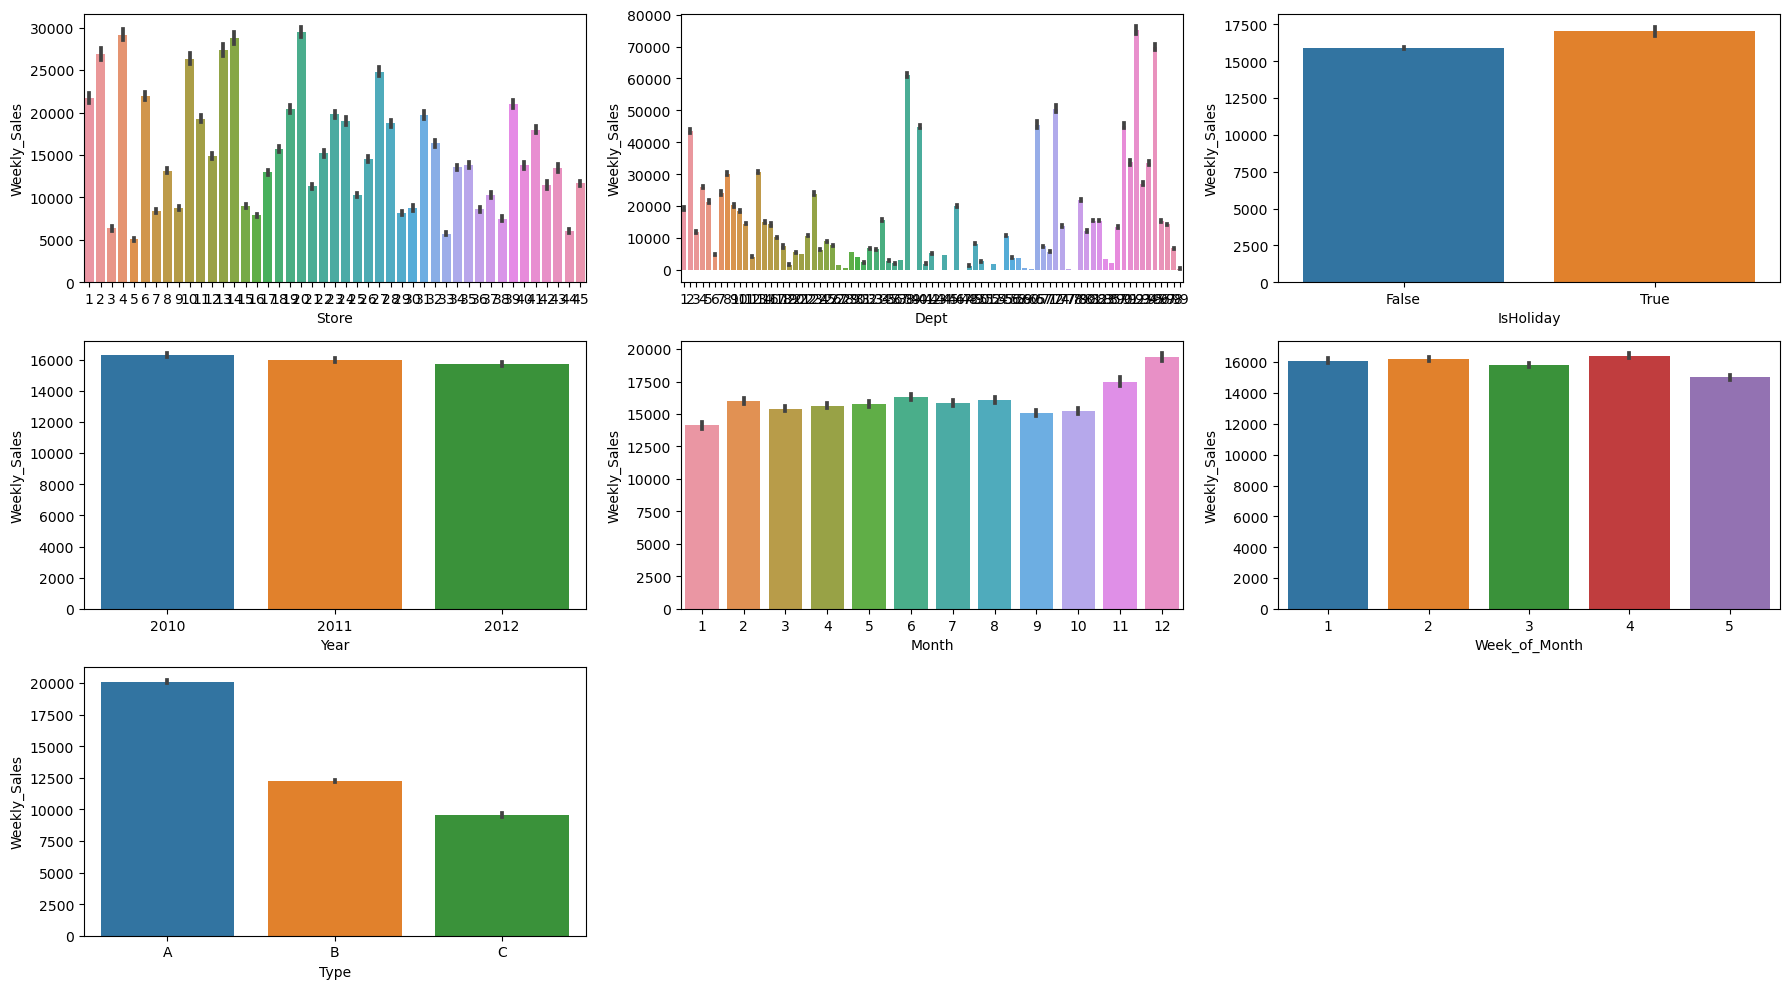

In [61]:
cat_plot(sales, category_columns, kind='barplot')

***Observations***

*Numeric Columns*

- Outliers exist, will treat acordingly.
- Maybe CPI should be considered as category with High >160 and low <160.
- Looking at the sizes column, it seems to be more scattered and sales took places for specific sizes. Instead of whole numbers, can we use the probablity here?

*Category Columns*

- Majority of the departments are giving average sales while some are way too high in performance whereas some are below.Shall create categories based on dept sales?
- Is the same thing being observed for store as well?

In [77]:
#Analyzing CPI

cpi = sales.copy()
cpi['CPI_Level'] = sales['CPI'].apply(lambda x : 1 if x >=160 else 0)
cpi.sample(10)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,Month,Week_of_Month,CPI_Level
292624,30,9,115.00,False,79.24,3.501,221.385275,6.891,C,42988,2012,6,1,1
350539,37,94,36134.76,False,86.02,3.523,214.487842,8.177,C,39910,2011,8,4,1
367120,39,30,3089.26,False,71.68,3.285,215.783133,7.716,A,184109,2011,10,2,1
302731,31,11,11671.79,False,82.51,3.256,221.561678,6.565,A,203750,2012,7,3,1
116226,12,60,378.00,False,84.83,4.103,130.889677,11.627,B,112238,2012,6,2,0
234544,24,25,7859.06,False,37.35,3.917,137.341103,8.659,A,203819,2012,2,4,0
320098,33,55,55.00,False,89.62,4.055,130.838161,7.147,A,39690,2012,8,4,0
251304,26,31,1364.18,False,47.17,3.988,134.435733,7.818,A,152513,2011,4,5,0
381984,41,30,2371.82,False,40.23,2.788,189.490412,7.363,A,196321,2010,5,3,1
415917,45,34,10395.59,False,41.76,3.625,184.994368,8.549,B,118221,2011,3,4,1


***CPI can be converted to a category***

In [91]:
#Analyzing Size

sales['Size'].value_counts(normalize=True)

39690     0.049344
39910     0.048858
203819    0.048334
219622    0.024845
126512    0.024468
205863    0.024366
151315    0.024300
202307    0.024285
204184    0.024255
158114    0.024252
203742    0.024228
202505    0.024221
203007    0.024200
203750    0.024058
206302    0.023989
196321    0.023930
207499    0.023868
114533    0.023839
200898    0.023816
155083    0.023761
123737    0.023486
155078    0.023472
184109    0.023431
93188     0.023398
120653    0.023386
152513    0.023375
128107    0.023256
70713     0.023156
112238    0.023021
119557    0.022981
118221    0.022860
140167    0.022729
103681    0.022601
93638     0.022428
57197     0.022400
37392     0.021434
34875     0.021346
125833    0.021033
42988     0.016975
41062     0.016014
Name: Size, dtype: float64

In [75]:
#Analyzing Department

dpt = sales.copy()
dpt['Dept_Level'] = sales['Weekly_Sales'].apply(lambda x : 2 if x >=45000 else 1 if x >=20000 and x<45000 else 0)
dpt.sample(10)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,Month,Week_of_Month,Dept_Level
278999,29,4,13858.33,False,68.99,2.770,132.693226,10.409,B,93638,2010,8,5,0
169723,18,6,5421.09,False,54.73,2.776,132.751667,9.331,B,120653,2010,10,2,0
243759,25,20,3425.82,False,33.09,3.413,212.068504,7.082,B,128107,2011,12,3,0
98438,11,33,9366.02,False,66.16,2.719,214.118080,7.343,A,207499,2010,4,1,0
96689,10,80,221.54,False,86.87,3.666,130.719633,7.170,B,126512,2012,7,2,0
66414,7,56,238.00,False,21.64,3.191,196.956530,8.256,B,70713,2012,3,1,0
80027,9,25,5532.25,False,78.51,2.642,214.656430,6.442,B,125833,2010,7,2,0
213392,22,67,11704.52,False,47.80,3.570,140.411161,7.706,B,119557,2011,11,2,0
361461,39,44,2804.41,False,61.88,2.667,210.141361,8.554,A,184109,2010,3,2,0
297568,31,31,2114.60,False,59.87,3.045,212.903312,8.028,A,203750,2011,2,3,0


***With Dept_Level column in place, now dept maybe can be removed***

In [76]:
#Analyzing Store

store = dpt.copy()
store['Store_Level'] = sales['Weekly_Sales'].apply(lambda x : 2 if x >=16000 else 1 if x >=8000 and x<16000 else 0)
store.sample(10)

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Year,Month,Week_of_Month,Dept_Level,Store_Level
228633,24,58,3763.00,False,75.27,2.924,132.582581,8.117,A,203819,2010,7,4,0,0
152885,16,27,1076.55,False,65.16,3.532,193.312548,6.338,B,57197,2011,7,3,0,0
281615,29,34,16021.63,False,62.59,4.034,134.767774,9.966,B,93638,2011,5,5,0,2
55080,6,20,7401.03,False,71.24,3.274,218.910984,6.551,A,202505,2011,10,3,0,0
166624,17,95,51634.51,False,70.98,3.545,130.790968,5.936,B,93188,2012,8,3,2,2
408161,44,9,219.87,False,52.76,3.752,129.049032,6.906,C,39910,2011,6,1,0,0
314824,33,87,14.88,False,93.52,3.057,126.111903,9.849,A,39690,2010,6,2,0,0
183637,19,94,31790.89,False,46.49,3.757,136.488452,7.866,A,203819,2011,10,5,1,2
313144,32,23,19711.07,False,75.09,3.528,198.029389,7.872,A,203007,2012,8,1,0,2
2750,1,27,1371.40,False,69.64,2.716,211.908844,7.838,A,151315,2010,10,5,0,0


***Similarly, we may remove store column as well***

39690     20802
39910     20597
203819    20376
219622    10474
126512    10315
205863    10272
151315    10244
202307    10238
204184    10225
158114    10224
203742    10214
202505    10211
203007    10202
203750    10142
206302    10113
196321    10088
207499    10062
114533    10050
200898    10040
155083    10017
123737     9901
155078     9895
184109     9878
93188      9864
120653     9859
152513     9854
128107     9804
70713      9762
112238     9705
119557     9688
118221     9637
140167     9582
103681     9528
93638      9455
57197      9443
37392      9036
34875      8999
125833     8867
42988      7156
41062      6751
Name: Size, dtype: int64